In [3]:
# import libraries
import os
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle

import pywt
import cv2

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split  
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 

import matplotlib.pyplot as plt

# resolusi gambar
shape = (512,512)

In [4]:
!python --version
print(sklearn.__version__)
print(pywt.__version__)
print(cv2.__version__)
print(tf.__version__)

Python 3.7.12
0.22.2.post1
1.1.1
4.1.2
2.6.0


In [ ]:
root = os.path.join("..","data")

In [5]:
image_path = []                                                                                             # membuat list kosong untuk lokasi image
label = []                                                                                                  # membuat list kosong untuk label sesuai dengan folder
for folder in os.listdir(root):                                                                             # loop setiap folder yang ada dalam folder data
  folder_path = os.path.join(root,folder)                                                                   # buat variable berisi path dari folder tiap kategori gambar
  for img in tqdm(os.listdir(folder_path)):                                                                 # loop tiap folder kategori gambar
    image_path.append(os.path.join(folder_path,img))                                                        # tambahkan path gambar ke list image_path
    label.append(folder)                                                                                    # tambahkan nama folder ke dalam list label
pd.DataFrame({                                                                                              # menampilkan path dan label dalam bentuk tabel
    "image":image_path,
    "label":label
})

,image,label
0,data/tidak retak/IMG_20211011_143501.jpg,tidak retak
1,data/tidak retak/IMG_20211011_143126.jpg,tidak retak
2,data/tidak retak/IMG_20211011_143418.jpg,tidak retak
3,data/tidak retak/IMG_20211011_142258.jpg,tidak retak
4,data/tidak retak/IMG_20211011_143833.jpg,tidak retak
...,...,...
214,data/retak garis/IMG_20210609_113019.jpg,retak garis
215,data/retak garis/IMG_20210609_112137.jpg,retak garis
216,data/retak garis/IMG_20210609_113231.jpg,retak garis
217,data/retak garis/IMG_20210609_111307.jpg,retak garis


In [6]:
img_array =[]
image = []
cats = []
for img,lbl in tqdm(zip(image_path,label)):                                                                
  arr = cv2.imread(img)                                                                                    
  arr = cv2.resize(arr,shape)                                                                              
  arr = cv2.cvtColor(arr, cv2.COLOR_BGR2LAB)                                                               
  l, a, b = cv2.split(arr)                                                                                 
  clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))                                               
  cl = clahe.apply(l)                                                                                      
  arr = cv2.merge((cl,a,b))                                                                                
  arr = cv2.cvtColor(arr, cv2.COLOR_LAB2BGR)                                                               
  arr = cv2.cvtColor(arr,cv2.COLOR_BGR2GRAY)                                                               
  coeffs2 = pywt.dwt2(arr, 'bior1.3')                                                                      
  LL, (LH, HL, HH) = coeffs2                                                                               
  img_array.append(np.array([LL,LH,HL,HH]))                                                                
  image.append(LL.tolist())                                                                                
  image.append(LH.tolist())                                                                                
  image.append(HL.tolist())                                                                                
  image.append(HH.tolist())                                                                                
  cats.append(lbl)                                                                                         
  cats.append(lbl)                                                                                         
  cats.append(lbl)                                                                                         
  cats.append(lbl)                                                                                         

219it [00:37,  5.82it/s]


In [ ]:
idx = random.randint(0,len(image_path))

In [ ]:
def print_array(n):                                                                                     
    print(label[n], image_path[n])                                                                      
    return img_array[n]                                                                                 

In [ ]:
print_array(idx)

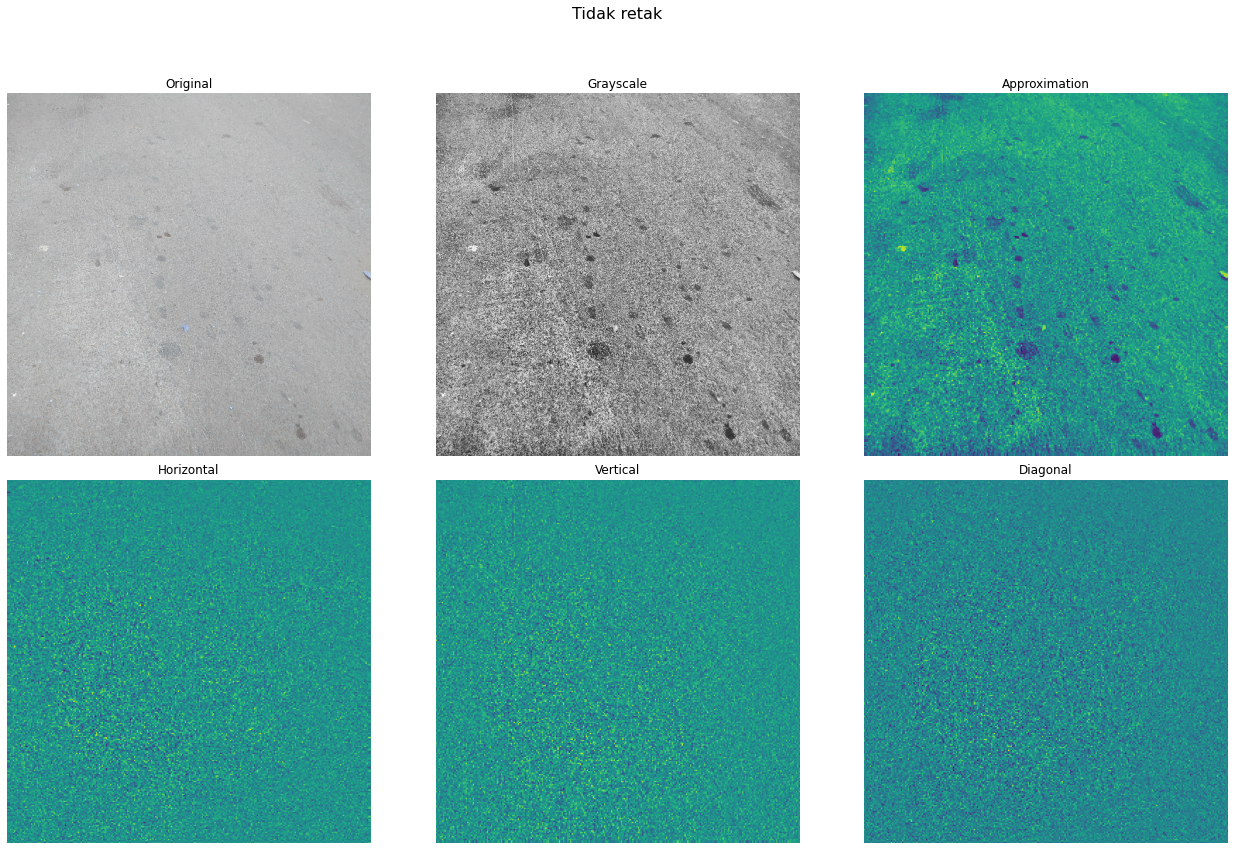

In [7]:
# testing dan menampilkan sample hasil transformasi
fig, ax = plt.subplots(nrows=2, ncols=3,figsize=(18,12))
fig.suptitle(label[idx].capitalize(), fontsize=16)
test = cv2.imread(image_path[idx])
orig = cv2.resize(test,shape)
ax[0, 0].imshow(orig)
test = cv2.cvtColor(orig, cv2.COLOR_BGR2LAB)
l, a, b = cv2.split(test)
clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))
cl = clahe.apply(l)
test = cv2.merge((cl,a,b))
test = cv2.cvtColor(test, cv2.COLOR_LAB2BGR)
gray = cv2.cvtColor(test,cv2.COLOR_BGR2GRAY)
ax[0, 1].imshow(gray)
coeffs2 = pywt.dwt2(gray, 'bior1.3')
LL, (LH, HL, HH) = coeffs2
WV = cv2.resize(LL,shape)
ax[0, 2].imshow(LL)
ax[1, 0].imshow(LH)
ax[1, 1].imshow(HL)
ax[1, 2].imshow(HH)
for x,t in zip(ax.ravel(),["Original","Grayscale","Approximation","Horizontal","Vertical","Diagonal"]):
  x.axis("off")
  x.set_title(t)
fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

In [ ]:
le = LabelEncoder()                                                                                                              
X = np.array(image)/255                                                                                                          
y = le.fit_transform(cats)                                                                                                       
le.classes_                                                                                                                      

array(['retak buaya', 'retak garis', 'tidak retak'], dtype='<U11')

In [ ]:
input_shape = (X.shape[1],X.shape[2])                                                                                      

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X),np.array(y), test_size=0.2, shuffle=True, random_state=42)   
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.2, shuffle=True, random_state=42)             
X_train = X_train.reshape(-1, input_shape[0], input_shape[1], 1)                                                             
X_val = X_val.reshape(-1, input_shape[0], input_shape[1], 1)                                                                 
X_test = X_test.reshape(-1, input_shape[0], input_shape[1], 1)                                                               

In [ ]:
model = Sequential()                                                                                                         
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(input_shape[0], input_shape[1],1)))                    
model.add(MaxPool2D())                                                                                                       

model.add(Conv2D(32, 3, padding="same", activation="relu"))                                                                  
model.add(MaxPool2D())                                                                                                       

model.add(Conv2D(64, 3, padding="same", activation="relu"))                                                                  
model.add(MaxPool2D())                                                                                                       
model.add(Dropout(0.4))                                                                                                      

model.add(Flatten())                                                                                                         
model.add(Dense(128,activation="relu"))                                                                                      
model.add(Dense(3, activation="softmax"))                                                                                    

model.summary()                                                                                                              

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 258, 258, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 129, 129, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 129, 129, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0

In [ ]:
model.compile(optimizer = "sgd" , loss = tf.keras.losses.SparseCategoricalCrossentropy() , metrics = ['accuracy'])                    

In [ ]:
history = model.fit(X_train,y_train,epochs = 500 , validation_data = (X_val, y_val))                                                  

Epoch 1/500
18/18 [==============================] - 33s 169ms/step - loss: 1.1034 - accuracy: 0.3268 - val_loss: 1.0914 - val_accuracy: 0.3571
Epoch 2/500
18/18 [==============================] - 2s 102ms/step - loss: 1.0987 - accuracy: 0.3464 - val_loss: 1.0889 - val_accuracy: 0.3286
Epoch 3/500
18/18 [==============================] - 2s 101ms/step - loss: 1.0890 - accuracy: 0.3696 - val_loss: 1.0955 - val_accuracy: 0.4786
Epoch 4/500
18/18 [==============================] - 2s 102ms/step - loss: 1.0850 - accuracy: 0.4393 - val_loss: 1.1002 - val_accuracy: 0.3714
Epoch 5/500
18/18 [==============================] - 2s 101ms/step - loss: 1.0795 - accuracy: 0.4679 - val_loss: 1.0680 - val_accuracy: 0.3929
Epoch 6/500
18/18 [==============================] - 2s 101ms/step - loss: 1.0699 - accuracy: 0.4786 - val_loss: 1.0660 - val_accuracy: 0.3929
Epoch 7/500
18/18 [==============================] - 2s 101ms/step - loss: 1.0492 - accuracy: 0.4982 - val_loss: 1.0507 - val_accuracy: 0.428

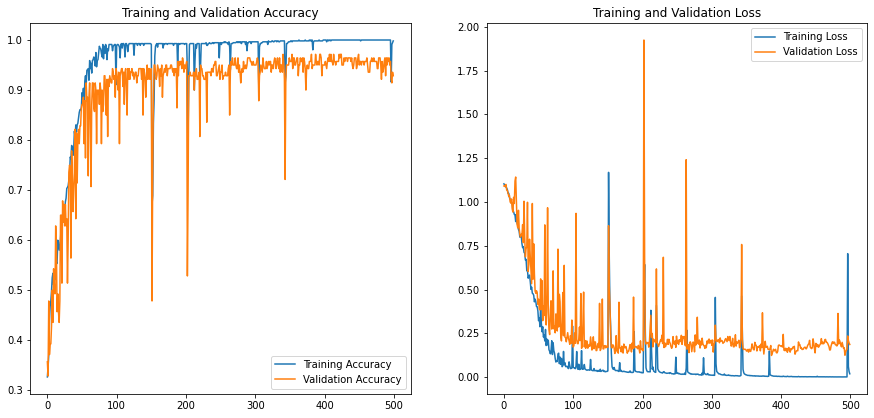

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(500)

plt.figure(figsize=(15, 15))                                                                 
plt.subplot(2, 2, 1)                                                                         
plt.plot(epochs_range, acc, label='Training Accuracy')                                       
plt.plot(epochs_range, val_acc, label='Validation Accuracy')                                 
plt.legend(loc='lower right')                                                                
plt.title('Training and Validation Accuracy')                                                

plt.subplot(2, 2, 2)                                                                         
plt.plot(epochs_range, loss, label='Training Loss')                                          
plt.plot(epochs_range, val_loss, label='Validation Loss')                                    
plt.legend(loc='upper right')                                                                
plt.title('Training and Validation Loss')                                                    
plt.show()                                                                                   

In [ ]:
loss,accuracy = model.evaluate(X_test, y_test, verbose=0)                                              
print('Model accuracy : ',accuracy)
print('Model loss     : ',loss)

Model accuracy :  0.9431818127632141
Model loss     :  0.20857834815979004


In [ ]:
predictions = model.predict(X_test)                                                                         
predictions = np.argmax(predictions, axis=-1)                                                               
print(classification_report(y_test, predictions, target_names = le.classes_))                               

              precision    recall  f1-score   support

 retak buaya       0.98      0.87      0.92        68
 retak garis       0.95      0.98      0.97        57
 tidak retak       0.89      1.00      0.94        51

    accuracy                           0.94       176
   macro avg       0.94      0.95      0.94       176
weighted avg       0.95      0.94      0.94       176



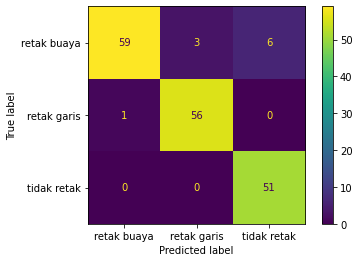

In [ ]:
cm = confusion_matrix(y_test, predictions)                                                                 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)                             
disp.plot()                                                                                                
plt.show()                                                                                                 

In [ ]:
# model.save(os.path.join("..","model/"))
# pickle.dump(le,open(os.path.join("..","model","le.sav","wb")))

INFO:tensorflow:Assets written to: /content/model/assets
